In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, RandomFlip# type: ignore
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG16, VGG19, ResNet152V2

from sklearn.metrics import confusion_matrix
RSEED = 34
main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\BreastUltrasound\\Dataset_BUSI_with_GT"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    files = os.listdir(main_path+"\\"+direct)
    if direct == "normal":
        code = 0
    elif direct == "benign":
        code = 1
    else:
        code = 2
    for file in files:
        if not file.endswith("_mask.png"):
            img = cv2.imread(main_path+"\\"+direct+"\\"+file)
            img = cv2.resize(img, (400,400))
            label_array = [0,0,0]
            label_array[code] = 1
            labels.append(label_array)
            images.append(img)


In [2]:
images = np.asarray(images)
labels = np.asarray(labels)
display("Shape of Images" , images.shape, "Label Shape", labels.shape)

'Shape of Images'

(798, 400, 400, 3)

'Label Shape'

(798, 3)

In [3]:
data = images/255.0

In [4]:
X_train,X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=RSEED)


In [5]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(400, 400, 3))

In [6]:
num_classes = 3

x = base_model.output
print(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

<KerasTensor shape=(None, 12, 12, 512), dtype=float32, sparse=False, name=keras_tensor_21>


In [7]:
for layer in model.layers[:-3]:
    layer.trainable = False
    

In [8]:
model = Sequential(
    [
        RandomFlip("horizontal"),
        model,
    ]
)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 409s 20s/step - accuracy: 0.5033 - loss: 11.2831
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 446s 22s/step - accuracy: 0.5347 - loss: 1.1006
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 391s 19s/step - accuracy: 0.6938 - loss: 0.7315
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 307s 15s/step - accuracy: 0.7443 - loss: 0.6349
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 326s 16s/step - accuracy: 0.7908 - loss: 0.5551
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 335s 17s/step - accuracy: 0.8361 - loss: 0.4693
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 326s 16s/step - accuracy: 0.8531 - loss: 0.4332
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 316s 16s/step - accuracy: 0.8532 - loss: 0.4073
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 314s 16s/step - accuracy: 0.9053 - loss: 0.3265
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 299s 15s/step - accuracy: 0.9027 - loss: 0.3196


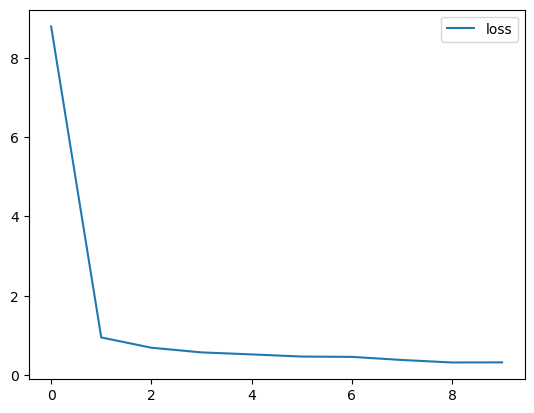

In [11]:
plt.plot(model.history.history['loss'], label='loss')
plt.legend()
plt.show()

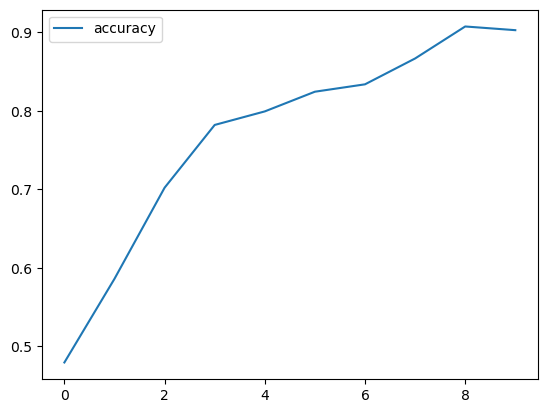

In [12]:
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [13]:
result = model.evaluate(X_test, y_test, batch_size=32)


print(f'The accuracy is {result[1]}')
print(f'The loss is {result[0]}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 72s 14s/step - accuracy: 0.7793 - loss: 0.5211
The accuracy is 0.800000011920929
The loss is 0.4866172671318054


In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 15s/step


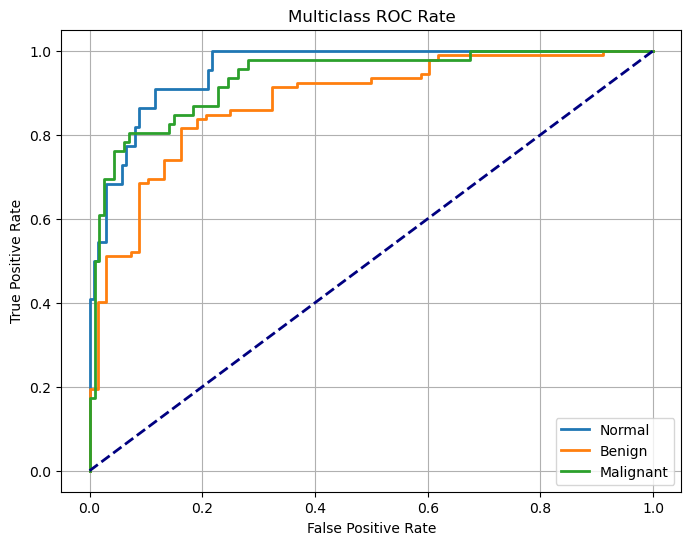

AUROC for class Normal : 0.957
AUROC for class Benign : 0.881
AUROC for class Malignant : 0.935


In [15]:
y_true = y_test
n_classes = y_true.shape[1]
fpr = {}
tpr = {}
roc_auc = {}
classes_names = {0:"Normal", 1:"Benign", 2:"Malignant"}
classes_names_list = ["Normal", "Benign", "Malignant"]

for i in range(n_classes):
    fpr[i], tpr[i],  _ =  roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i],tpr[i])

plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], 
        lw=2,
        label=f"Class {i} (area = {roc_auc[i]:.3f})"

    )

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Rate")
plt.legend(classes_names_list, loc="lower right")
plt.grid()
plt.show()

for i in range(n_classes):
    print(f"AUROC for class {classes_names[i]} : {roc_auc[i]:.3f}")


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 3)              │    38,899,779 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,650,571 (292.40 MB)

 Trainable params: 18,875,395 (72.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 37,750,792 (144.01 MB)

In [17]:
model.save("breast_uss_normal_bening_malignant_vgg16_model.keras")

In [18]:
from tensorflow.keras.models import load_model
model = load_model("breast_uss_normal_bening_malignant_vgg16_model.keras")